
# Adding Regularization and Penalty Terms to Fitting

This example is nearly identical to the Synthetic Data fit, however we
use a more sophisticated loss function, introducing an additional first-order 
penalty term. The previous synthetic fit relied only on MSE loss and a second-order penalty. 
All other models remain the same: Mann turbulence under the Kaimal spectra. 


See again the [original DRD paper](https://arxiv.org/abs/2107.11046).


## Import packages

First, we import the packages we need for this example. Additionally, we choose to use
CUDA if it is available.



In [1]:
import torch
import torch.nn as nn

from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# Scales associated with Kaimal spectrum
L = 0.59  # length scale
Gamma = 3.9  # time scale
sigma = 3.2  # energy spectrum scale

Uref = 21.0  # reference velocity
zref = 1  # reference height

domain = torch.logspace(-1, 2, 20)

%%
Now, we construct our ``CalibrationProblem``.

Compared to the first Synthetic Fit example, we are instead using GELU
activations and will train for fewer epochs. The more interesting difference
is that we will have activated a first order term in the loss function by passing
``alpha_pen1`` a value in the ``LossParameters`` constructor.



In [2]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=2,
        hidden_layer_sizes=[10, 10],
        activations=[nn.GELU(), nn.GELU()],
    ),
    prob_params=ProblemParameters(nepochs=5),
    loss_params=LossParameters(alpha_pen2=1.0, alpha_pen1=1.0e-5, beta_reg=2e-4),
    phys_params=PhysicalParameters(L=L, Gamma=Gamma, sigma=sigma, domain=domain),
    logging_directory="runs/synthetic_3term",
    device=device,
)

In the following cell, we construct our $k_1$ data points grid and
generate the values. ``Data`` will be a tuple ``(<data points>, <data values>)``.
It is worth noting that the second element of each tuple in ``DataPoints`` is the
corresponding reference height, which we have chosen to be uniformly `zref`.



In [3]:
Data = OnePointSpectraDataGenerator(zref=zref, data_points=domain).Data

## Calibration
Now, we fit our model. ``CalibrationProblem.calibrate`` takes the tuple ``Data``
which we just constructed and performs a typical training loop.



In [4]:
optimal_parameters = pb.calibrate(data=Data)

pb.print_calibrated_params()

Initial loss: 0.048342988060472554


  0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

 20%|██████████████████▏                                                                        | 1/5 [00:03<00:14,  3.66s/it]

 40%|████████████████████████████████████▍                                                      | 2/5 [00:05<00:08,  2.83s/it]

 60%|██████████████████████████████████████████████████████▌                                    | 3/5 [00:08<00:05,  2.57s/it]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [00:10<00:02,  2.48s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.40s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]

Spectra fitting concluded with final loss: 0.006719365444343754
Optimal calibrated L     :   0.6268 
Optimal calibrated Gamma :   3.4610 
Optimal calibrated sigma :   3.0053 


## Plotting
``DRDMannTurb`` offers built-in plotting utilities and Tensorboard integration
which make visualizing results and various aspects of training performance
very simple. The training logs can be accessed from the logging directory
with Tensorboard utilities, but we also provide a simple internal utility for a single
training log plot.

The following will plot our fit.



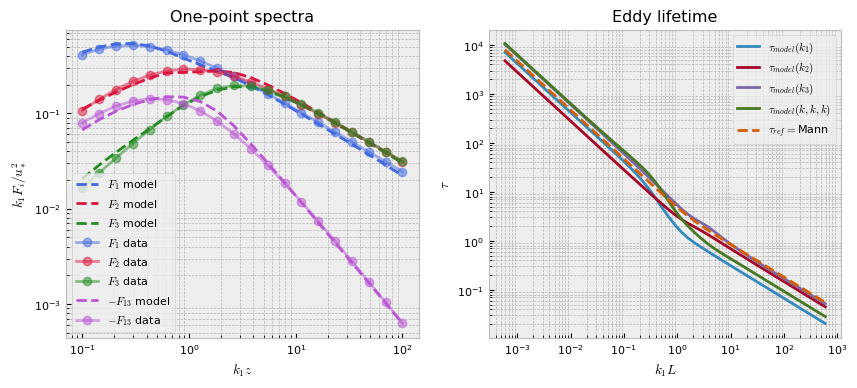

In [5]:
pb.plot()

This plots out the loss function terms as specified, each multiplied by the
respective coefficient hyperparameter.



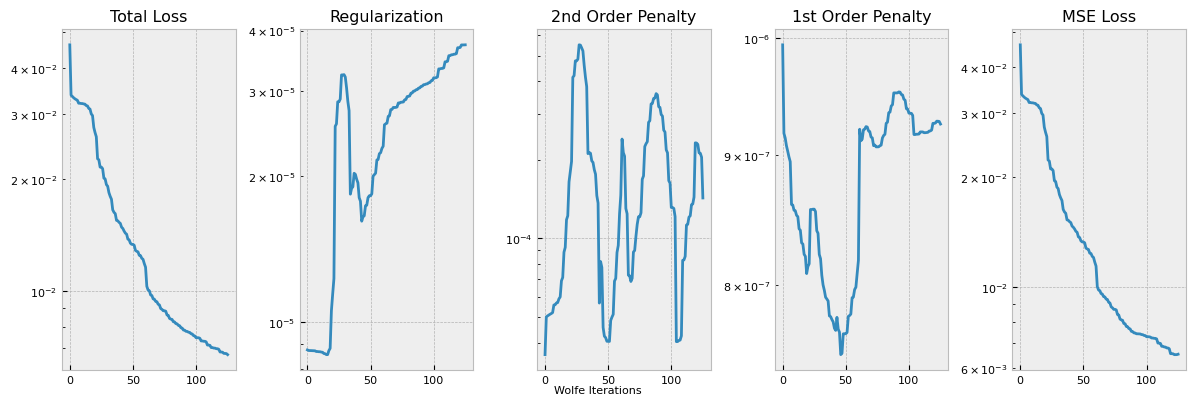

In [6]:
pb.plot_losses(run_number=0)